# Computes s/b and sample composition in a region
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- computes s/b and sample composition in a region defied by a cut
- make plots of s/b as function of cut thresholds
- implements an optimum finding algoritihm for the cut that maximizes s/b (at the end of the notebook)

In [1]:
import glob
import os
import json
import pickle
import yaml

import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils
plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
! ls ../eos/Apr12_presel_2017

DYJetsToLL_M-10to50                     SingleElectron_Run2017E
DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to32

In [4]:
presel = {
    "mu": {
        
        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        
        ### signal region
#         "tagger": " ( ( inclusive_score>0.9) )",
        
        ### top region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_L == 0) )",      

        ### qcd control region
#         "tagger": " ( ( inclusive_score<0.9) )",        
    },
    "ele": {
        
        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",

        ### signal region
#         "tagger": " ( ( inclusive_score>0.9) )",
        
        ### top control region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_L == 0) )",     
        
        ### qcd control region
#         "tagger": " ( ( inclusive_score<0.9) )",
        
    }    
}

weights = {
    "ele": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_electron": 1,
        "weight_pileup": 1,
        "weight_reco_electron": 1,
        "weight_trigger_electron": 1,
        "weight_vjets_nominal": 1,
    },
    "mu": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_muon": 1,
        "weight_isolation_muon": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_vjets_nominal": 1   ,
    },       
}

In [5]:
years = ["2017", "2016", "2016APV", "2018"]
years = ["2017"]

channels = ["mu", "ele"]

# samples_dir = f"../eos/Apr12_presel_"
# samples_dir = f"../eos/Jul15_region_wjets_"
# samples_dir = f"../eos/Jul12QCD_"
samples_dir = f"../eos/Sep28_hidNeurons_"

samples = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
#     "Data"
]

In [7]:
from finetuned_make_stacked_hists import make_events_dict
events_dict = make_events_dict(years, channels, samples_dir, samples, presel, weights)

INFO:root:Finding DYJetsToLL_M-50_HT-600to800 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 104668 events
INFO:root:---> Done with preselection
INFO:root:Will fill the DYJets dataframe with the remaining 104668 events
INFO:root:tot event weight 2345.264165644301 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 4407 events
INFO:root:---> Done with preselection
INFO:root:Will fill the WJetsLNu dataframe with the remaining 4407 events
INFO:root:tot event weight 8579.715524733674 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 23063 e

INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 15129 events
INFO:root:---> Done with preselection
INFO:root:Will fill the VH dataframe with the remaining 15129 events
INFO:root:tot event weight 17.817613479686816 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 195 events
INFO:root:---> Done with preselection
INFO:root:Will fill the WJetsLNu dataframe with the remaining 195 events
INFO:root:tot event weight 420.9874222855761 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 36615 events
INFO:root:---> Done with preselection
INFO:root:Will fill the SingleTop dataframe wi

INFO:root:tot event weight 55848.96246555758 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 175965 events
INFO:root:---> Done with preselection
INFO:root:Will fill the WJetsLNu dataframe with the remaining 175965 events
INFO:root:tot event weight 23083.516150796302 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 682 events
INFO:root:---> Done with preselection
INFO:root:Will fill the WZQQ dataframe with the remaining 682 events
INFO:root:tot event weight 160.50036029078197 

INFO:root:Finding DYJetsToLL_M-50_HT-100to200 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:ro

INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 866757 events
INFO:root:---> Done with preselection
INFO:root:Will fill the TTbar dataframe with the remaining 866757 events
INFO:root:tot event weight 83889.22268526941 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 848637 events
INFO:root:---> Done with preselection
INFO:root:Will fill the DYJets dataframe with the remaining 848637 events
INFO:root:tot event weight 6680.856365330962 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 56496 events
INFO:root:---> Done with preselection
INFO:root:Will fill the SingleTo

INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 634 events
INFO:root:---> Done with preselection
INFO:root:Will fill the QCD dataframe with the remaining 634 events
INFO:root:tot event weight 0.06287263450811714 

INFO:root:Finding DYJetsToLL_Pt-650ToInf samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 118402 events
INFO:root:---> Done with preselection
INFO:root:Will fill the DYJets dataframe with the remaining 118402 events
INFO:root:tot event weight 111.86718745366124 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 470 events
INFO:root:---> Done with preselection
INFO:root:Will fill the WZQQ dataframe with the remaining 

INFO:root:tot event weight 718.5345690194665 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 77794 events
INFO:root:---> Done with preselection
INFO:root:Will fill the WJetsLNu dataframe with the remaining 77794 events
INFO:root:tot event weight 43188.72475023142 

INFO:root:Finding QCD_Pt_470to600 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr selection on 2036 events
INFO:root:---> Done with preselection
INFO:root:Will fill the QCD dataframe with the remaining 2036 events
INFO:root:tot event weight 2373.4313213261657 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:---> Applying preselection
INFO:root:applying lep_fj_dr sel

In [27]:
events_dict.keys()

dict_keys(['2017'])

In [28]:
events_dict["2017"].keys()

dict_keys(['mu', 'ele'])

In [29]:
events_dict["2017"]["mu"].keys()

dict_keys(['ggF'])

In [34]:
df = events_dict["2017"]["mu"]["ggF"]

In [35]:
df

,fj_msoftdrop,lep_pt,lep_isolation,lep_misolation,lep_fj_dr,lep_met_mt,met_fj_dphi,met_pt,deta,mjj,...,weight_ele_scalevar_7ptUp,weight_ele_aS_weightUp,weight_ele_PDF_weightDown,weight_ele_btagSFbc_correlatedUp,weight_ele_reco_electronDown,fj_ParT_score,fj_ParT_mass,event_weight,met_relpt,fj_ParT_score_finetuned
0,76.513114,130.759888,0.012202,0.000000,0.220553,67.827492,1.519893,16.892807,2.125000,267.207031,...,0.561888,0.472696,0.451528,0.450261,0.449815,0.992916,131.021332,0.007949,0.067233,0.981446
1,88.254057,55.177658,0.181231,0.135773,0.437613,23.177322,0.403372,119.684608,0.274658,300.204102,...,0.634647,0.540611,0.512961,0.575960,0.507987,0.759613,137.666000,0.009791,0.443798,0.845096
2,55.767155,54.517136,0.065889,0.008026,0.365316,12.570642,0.982255,6.737134,NaN,NaN,...,0.755028,0.636182,0.608460,0.730747,0.606376,0.969110,93.473877,0.010981,0.031762,0.584320
3,49.734290,131.698685,0.027519,0.000000,0.123454,29.888674,-0.404748,84.583084,NaN,NaN,...,0.697519,0.579497,0.548942,0.690442,0.527033,0.521470,90.901756,0.009886,0.380524,0.585537
4,13.886867,106.866577,0.979213,0.000000,0.058721,16.406254,0.391684,15.820980,NaN,NaN,...,0.667363,0.543320,0.520369,0.613133,0.518542,0.387763,25.736118,0.009344,0.064060,0.474883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17888,45.605441,30.377645,0.084716,0.074298,0.411899,23.639198,0.018651,155.823898,2.784424,778.157959,...,0.444171,0.355912,0.339848,0.426294,0.339114,0.997325,70.973648,0.010183,0.724801,0.920651
17889,55.366671,131.194305,0.477823,0.042352,0.190265,125.957169,2.052118,40.837822,1.228577,128.573517,...,0.675160,0.595629,0.565537,0.668770,0.563345,0.997533,84.056030,0.009955,0.139133,0.924383
17890,36.745674,132.020554,0.422639,0.000000,0.113511,130.667236,1.198443,97.676064,0.294189,84.915764,...,0.718316,0.598833,0.570749,0.685365,0.568882,0.809432,75.492355,0.010720,0.363399,0.693720
17891,43.091953,123.500076,0.080575,0.000000,0.138286,36.099842,-0.471557,64.575356,NaN,NaN,...,0.526897,0.450001,0.430945,0.426919,0.428195,0.266281,87.837059,0.008069,0.290859,0.337964


In [ ]:
scipy.special.softmax()

# Compute s/b

In [146]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD"]

samples = events_dict["2017"]["mu"].keys()
samples

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttH'])

In [160]:
num_sig, num_bkg = {}, {}
num_bkg["Other"] = 0

deno_sig, deno_bkg = 0, 0
s, b = 0, 0

tagger_cut = 0.9

# event weights
for sample in samples:
    if sample=="Data":
        continue
        
    df_mu = events_dict["2017"]["mu"][sample]
    df_ele = events_dict["2017"]["ele"][sample]
    
    ### signal region
    # add tagger cut
#     df_mu = df_mu[df_mu["inclusive_score"]>tagger_cut]
#     df_ele = df_ele[df_ele["inclusive_score"]>tagger_cut]
    
    df_mu = df_mu[df_mu["inclusive_score2"]>0.99]
    df_ele = df_ele[df_ele["inclusive_score2"]>0.99]

#     df_mu = df_mu[df_mu["fj_pt"]/df_mu["lep_pt"]>1.6]
#     df_ele = df_ele[df_ele["fj_pt"]/df_ele["lep_pt"]>1.6]  
    
    
#     # dR cut
#     df_mu = df_mu[df_mu["lep_fj_dr"]<0.35]
#     df_ele = df_ele[df_ele["lep_fj_dr"]<0.35]
    
# # #     # nbjets cut
#     df_mu = df_mu[df_mu["n_bjets_T"]>=1]
#     df_ele = df_ele[df_ele["n_bjets_T"]>=1]
    
#     df_mu = df_mu[df_mu["n_bjets_L"]==0]
#     df_ele = df_ele[df_ele["n_bjets_L"]==0]
#     # VBF
#     df_mu = df_mu[df_mu["mjj"]>1000]
#     df_ele = df_ele[df_ele["mjj"]>1000]        
    
#     df_mu = df_mu[df_mu["deta"]>3.5]
#     df_ele = df_ele[df_ele["deta"]>3.5]        
    
#     df_mu = df_mu[np.abs(df_mu["met_fj_dphi"])<2]
#     df_ele = df_ele[np.abs(df_ele["met_fj_dphi"])<2]    

    ##############################    

    if sample in utils.signals:
        deno_sig += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
        num_sig[sample] = df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
    else:
        deno_bkg += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()         
        if sample in dominant_backgrounds:
            num_bkg[sample] = df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
        else:
            num_bkg["Other"] += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
        
num_sig["ggF"] = num_sig.pop("HWW")

num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))


print(f"Yuzhe's definition:")
print("Tagger>0.99")

print(rf"s/b: {deno_sig/(deno_bkg):.3f}")
print(rf"s/sqrt(b): {deno_sig/math.sqrt(deno_bkg):.2f}")
print("------------------------")
print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
#     print(f"- {sample}: {(num_sig[sample]/deno_sig):.3f}%")
    
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")  
#     print(f"- {sample}: {(num_bkg[sample]/deno_bkg):.3f}%")      

Yuzhe's definition:
Tagger>0.99
s/b: 0.010
s/sqrt(b): 0.93
------------------------
Signal: 88.02
- ttH: 8%
- VH: 16%
- VBF: 25%
- ggF: 51%
------------------------
Background: 8873.15
- QCD: 6%
- Other: 7%
- TTbar: 14%
- WJetsLNu: 74%


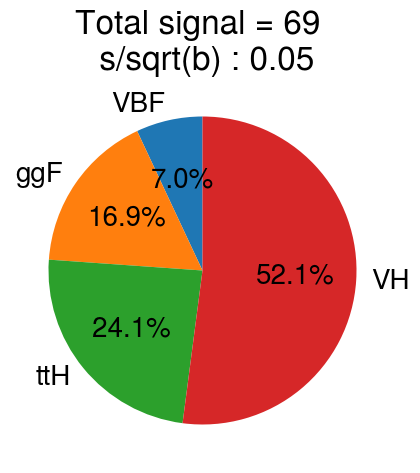

In [16]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(7, 5))
# Create the pie chart

patches, texts, autotexts = ax.pie(num_sig.values(), labels=num_sig.keys(), autopct='%1.1f%%', startangle=90)
for text in texts:
    text.set_size(20)
for autotext in autotexts:
    autotext.set_color('black')
    
# Add a title
plt.title(f"Total signal = {sum(list(num_sig.values())):.0f} \n s/sqrt(b) : {deno_sig/math.sqrt(deno_bkg):.2f}")

plt.show()

# Check s/b as a function of a cut

In [12]:
samples = events_dict["2017"]["mu"].keys()
tagger_cuts = [0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 0.99]

s_over_b = {}
for tagger in ["fj_ParT_score", "fj_ParT_score_finetuned"]:
    print("TAGGER:", tagger)
    s_over_b[tagger] = []
    
    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for sample in samples:

            df_mu = events_dict["2017"]["mu"][sample]
            df_ele = events_dict["2017"]["ele"][sample]

            # add tagger cut
            df_mu = df_mu[df_mu[tagger]>tagger_cut]
            df_ele = df_ele[df_ele[tagger]>tagger_cut]

            ##############################    
            if sample in utils.signals:
                s += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
            else:
                b += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()

        s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.85
tagger cut 0.875
tagger cut 0.9
tagger cut 0.925
tagger cut 0.95
tagger cut 0.975
tagger cut 0.99
TAGGER: fj_ParT_score_finetuned
tagger cut 0.85
tagger cut 0.875
tagger cut 0.9
tagger cut 0.925
tagger cut 0.95
tagger cut 0.975
tagger cut 0.99


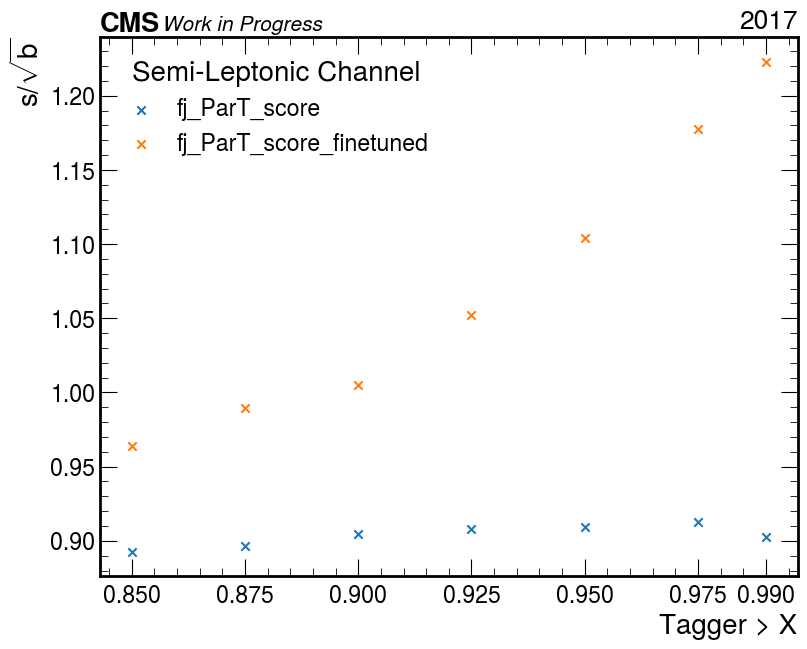

In [13]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(9, 7))
for tagger in s_over_b:
    ax.scatter(tagger_cuts, s_over_b[tagger], marker="x", label=tagger)

ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"$s/\sqrt{b}$"); 
ax.set_xlabel(r"Tagger > X");
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
ax.set_xticks(tagger_cuts)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig("/Users/fmokhtar/Desktop/lol2.pdf")

In [25]:
dr_cuts = np.linspace(0.1,0.8,21)

s_over_b = {}
for tagger_cut in [0, 0.9, 0.99]:
    s_over_b[tagger_cut] = []
    
    for dr_cut in dr_cuts:
        num_sig, num_bkg = {}, {}
        deno_sig, deno_bkg = 0, 0
        s, b = 0, 0
        for sample in ["HWW", "ttH", "VBF", "VH", "TTbar", "QCD", "WJetsLNu", "DYJets"]:

            df_mu = events_dict["2017"]["mu"][sample]
            df_ele = events_dict["2017"]["ele"][sample]

            ### signal region
            # add tagger cut
            df_mu = df_mu[df_mu["inclusive_score"]>tagger_cut]
            df_ele = df_ele[df_ele["inclusive_score"]>tagger_cut]

            # dR cut
            df_mu = df_mu[df_mu["lep_fj_dr"]<dr_cut]
            df_ele = df_ele[df_ele["lep_fj_dr"]<dr_cut] 
            
            # nbjets?
            df_mu = df_mu[df_mu["n_bjets_M"]<2]
            df_ele = df_ele[df_ele["n_bjets_M"]<2]            
            
            ##############################    
            if sample in utils.signals:
                num_sig[sample] = df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
                deno_sig += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
            else:
                num_bkg[sample] = df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
                deno_bkg += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()

        s_over_b[tagger_cut].append(deno_sig/math.sqrt(deno_bkg))

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

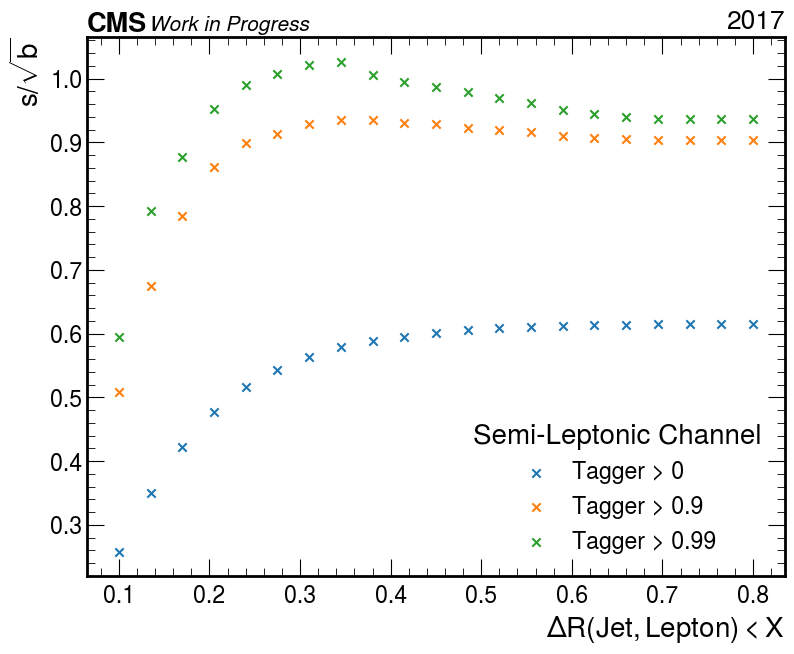

In [26]:
plt.rcParams.update({"font.size": 20})
### save plot
fig, ax = plt.subplots(figsize=(9, 7))
for tagger_cut in s_over_b:
    ax.scatter(dr_cuts, s_over_b[tagger_cut], marker="x", label=f"Tagger > {tagger_cut}")

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"$s/\sqrt{b}$"); 
ax.set_xlabel(r"$\Delta R(Jet,Lepton) < X$");
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

# Optimum finding algorithm

In [40]:
from tqdm.notebook import tqdm
def get_optimum_s_over_b(vars_, steps, apply_tagger=False):
    """
    Idea: given a range, fix the lower limit and do a "for loop" where you slide the upper limit to the left until 
    you hit the lower limit. Then increase the lower limit by one step and repeat.
    
    NOTE: for computational costs, and assuming the steps are always about a nice gaussian;
    the lower limit does not bypass the midpoint.
    """

    s, b = {}, {}
    
    midpoint = steps.mean()
    for low in tqdm(steps):
        if low>midpoint:
            break
        for high in tqdm(steps):
            if high<=low:
                continue
        
            s[f"{low:.2f}-{high:.2f}"], b[f"{low:.2f}-{high:.2f}"] = 0, 0
        
            for ch in channels:   # sum over channels
                for sample in events_dict["2017"][ch]:
                    df = events_dict["2017"][ch][sample]

                    ### apply tagger cut
                    if apply_tagger:
                        keep = ( df["inclusive_score"]>0.9 )
                        df = df.loc[keep, :]

                    # selection
                    if len(vars_)==2:
                        keep = ( df[vars_[0]]/df[vars_[1]]>low ) & ( df[vars_[0]]/df[vars_[1]]<high ) 
                    else:
                        keep = ( df[vars_[0]]>low ) & ( df[vars_[0]]<high )
    
                    df = df.loc[keep, :]            

                    ### mass window
                    mass_window = (df["fj_minus_lep_m"]>0) & (df["fj_minus_lep_m"]<150)

                    ### s/b
                    ev_weight = df["event_weight"]        
                    if sample in utils.signals:
                        s[f"{low:.2f}-{high:.2f}"] += ev_weight[mass_window].sum()
                    else:
                        b[f"{low:.2f}-{high:.2f}"] += ev_weight[mass_window].sum()   
         
    max_ = 0
    for range_ in s:
        s_over_b = s[range_]/np.sqrt(b[range_])
        if s_over_b >= max_:
            max_ = s_over_b
    
    for range_ in s:
        s_over_b = s[range_]/np.sqrt(b[range_])
        if s_over_b >= max_:
            print("range: s/b")    
            print(f"{range_} : {s[range_]/np.sqrt(b[range_]):.2f}")    
        
    return s, b

# dR(Jet,Lepton)

In [43]:
steps = np.linspace(0, 0.8, 11)
steps 

array([0.  , 0.08, 0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 ])

In [44]:
s, b = get_optimum_s_over_b(["lep_fj_dr"], steps, apply_tagger=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

range: s/b
0.00-0.40 : 0.66


# pT(Jet)/pT(Lepton)

In [46]:
steps = np.linspace(0, 10, 11)
steps 

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [47]:
s, b = get_optimum_s_over_b(["fj_pt", "lep_pt"], steps, apply_tagger=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

range: s/b
0.00-10.00 : 0.65
range: s/b
1.00-10.00 : 0.65


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_62462/2161202164.py:52: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b = s[range_]/np.sqrt(b[range_])
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_62462/2161202164.py:57: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b = s[range_]/np.sqrt(b[range_])


# pT(W_lnu)/pT(W_qq)

In [48]:
steps = np.linspace(0, 10, 11)
steps

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [49]:
s, b = get_optimum_s_over_b(["rec_W_lnu_pt", "rec_W_qq_pt"], steps, apply_tagger=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

range: s/b
0.00-9.00 : 0.65
